In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import os
import time
import datetime as dt 
import yfinance as yf
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import alphalens as al
import warnings

from functions.datareader import pull_stock_data, YFinanceReader

warnings.filterwarnings('ignore')

<h1 style="color:orange">Load data using YFinance and save to local</h1>

In [2]:
# source for yfinance: https://pypi.org/project/yfinance/
start = dt.date(2015, 1, 1)
end = dt.date(2022, 2, 1)

# * parameters
ANNUALIZATION_FACTOR = 252

In [3]:
sectors = {
    'banking': ['BBL', 'KBANK', 'SCB', 'BAY', 'TISCO', 'KTB', 'KKP', 'TTB'],
    'hospital': ['BDMS', 'BCH', 'BH', 'THG', 'PR9', 'EKH', 'IMH', 'RJH', 'RPH', 'MEGA', 'KLINIQ'],
    'infrastructure': ['AOT', 'BAFS', 'BEM', 'DMT'],
    'consumer_staple': ['BJC', 'OR', 'CPALL', 'CRC', 'MAJOR', 'GFPT', 'CPF', 'MAKRO', 'M', 'TU', 'TC'],
    'consumer_discretionary': ['COM7', 'CPW', 'SYNEX', 'JUBILE', 'CPH'],
    'technology': ['BBIK', 'IIG', 'BE8'],
    'industrial': ['WHA', 'AMATA'],
    'material': ['SCGP', 'HMPRO', 'GLOBAL', 'DOHOME', 'TPIPL', 'STGT', 'THMUI'],
    'utilities': ['RATCH', 'BGRIM', 'GULF', 'TPIPP', 'EGCO', 'EA', 'BANPU', 'BPP', 'ACE'],
    'petrochemistry': ['PTTGC', 'BCP', 'IRPC', 'IVL'],
    'real_estate': ['SIRI', 'QH', 'AP', 'SPALI', 'ORI', 'LALIN', 'SENA', 'BRI'],
    'hotel': ['MINT', 'CENTEL', 'ERW', 'AWC', 'SPA'],
    'consumer_finance': ['SAWAD', 'KTC', 'AEONTS', 'TIDLOR', 'MTC'],
    'insurance': ['BLA']
}

all_tickers = sectors.values()
all_tickers = [v + '.BK' for s in all_tickers for v in s]

In [4]:
# yfr = YFinanceReader(stock_sectors = sectors)
# yfr.load_data()
# yfr.save('./data/set')

<h1 style="color:salmon">Load data from local and use only close price</h1>

In [5]:
raw_df = pd.read_parquet('./data/set')

# convert index from datetime to date
# raw_df.index = raw_df.index.date
raw_df.set_index(pd.DatetimeIndex(raw_df.index))
raw_df.index.name = 'date'

raw_df.tail()

,ticker,close,dividends,high,low,open,stock splits,volume
date,,,,,,,,
2023-03-27,WHA,4.24,0.0,4.26,4.22,4.24,0.0,59546000.0
2023-03-28,WHA,4.26,0.0,4.30,4.24,4.26,0.0,58285000.0
2023-03-29,WHA,4.26,0.0,4.30,4.22,4.26,0.0,23513800.0
2023-03-30,WHA,4.22,0.0,4.28,4.20,4.26,0.0,62419000.0
2023-03-31,WHA,4.30,0.0,4.32,4.24,4.24,0.0,64002600.0


In [6]:
# map sector using the sector dict above
vk = [(k, v) for k, v in sectors.items()]
sector_mapper = {sub: s[0]for s in vk for sub in s[1]}
raw_df['sector'] = raw_df['ticker'].map(sector_mapper)


<p>We'll define a starting period of our analysis. Therefore we'll need to know whether there are stocks of which the daily price data doesn't exist yet in that period.</p>

In [7]:
start_date = dt.date(2015, 1, 1)

first_date_df = raw_df[['ticker']].reset_index().groupby('ticker').min()
first_date_df['is_available_since_start'] = first_date_df['date'].apply(lambda x: True if x <= start_date else False)

available_tickers = first_date_df[first_date_df['is_available_since_start'] == True].reset_index()['ticker']

# create a sector_mapper of available stocks
sector_mapper_available = {s:sector_mapper[s] for s in sector_mapper if s in available_tickers.values}

In [8]:
# filter only selected stocks
df = raw_df.reset_index().merge(available_tickers, left_on = 'ticker', right_on = 'ticker').set_index('date')
df.head()

,ticker,close,dividends,high,low,open,stock splits,volume,sector
date,,,,,,,,,
2001-12-11,AEONTS,4.823158,0.0,5.126979,4.405404,4.481359,0.0,78469000.0,consumer_finance
2001-12-12,AEONTS,4.709224,0.0,5.013045,4.709224,4.937090,0.0,31076500.0,consumer_finance
2001-12-13,AEONTS,4.557314,0.0,4.785180,4.557314,4.747202,0.0,11258000.0,consumer_finance
2001-12-14,AEONTS,4.823158,0.0,4.899113,4.443382,4.557315,0.0,19788500.0,consumer_finance
2001-12-17,AEONTS,4.823158,0.0,4.899113,4.823158,4.899113,0.0,3423000.0,consumer_finance


In [9]:
close_df = df[['ticker', 'sector', 'close']]
close_df.head()

,ticker,sector,close
date,,,
2001-12-11,AEONTS,consumer_finance,4.823158
2001-12-12,AEONTS,consumer_finance,4.709224
2001-12-13,AEONTS,consumer_finance,4.557314
2001-12-14,AEONTS,consumer_finance,4.823158
2001-12-17,AEONTS,consumer_finance,4.823158


In [10]:
# calculate daily return 
close_df_pivot = close_df.reset_index().pivot(index = 'date', columns = 'ticker', values = 'close')
daily_return_df = close_df_pivot.pct_change()
daily_return_df = daily_return_df[daily_return_df.index.date >= start_date]
daily_return_df.head(2)

ticker,AEONTS,AMATA,AOT,AP,BAFS,BANPU,BAY,BBL,BCH,BCP,...,SIRI,SPA,SPALI,SYNEX,TC,TISCO,TPIPL,TTB,TU,WHA
date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.004608,0.025478,-0.031915,0.000000,-0.024000,-0.012048,-0.050279,-0.020619,0.018987,-0.015748,...,-0.029412,0.004902,0.000000,0.000000,0.000,0.017647,0.023392,-0.034247,-0.027839,-0.015873
2015-01-06,0.004630,0.000000,-0.003663,-0.008403,0.016393,0.008130,-0.005882,-0.002631,0.012422,-0.008000,...,-0.006061,0.019512,-0.016597,0.007092,-0.005,0.005781,0.057143,-0.014184,-0.036364,-0.032258


In [11]:
# annualized calculcate covariance matrix
return_covmat = daily_return_df.cov().mul(ANNUALIZATION_FACTOR)
return_covmat.tail(2)

ticker,AEONTS,AMATA,AOT,AP,BAFS,BANPU,BAY,BBL,BCH,BCP,...,SIRI,SPA,SPALI,SYNEX,TC,TISCO,TPIPL,TTB,TU,WHA
ticker,,,,,,,,,,,,,,,,,,,,,
TU,0.009337,0.018705,0.010247,0.009822,0.007305,0.014601,0.008501,0.011438,0.009290,0.014922,...,0.01397,0.015070,0.010553,0.019343,0.016170,0.007963,0.012669,0.016362,0.077905,0.018490
WHA,0.036875,0.067116,0.035200,0.031031,0.025137,0.037051,0.028622,0.028153,0.024774,0.032794,...,0.03886,0.037142,0.027026,0.035341,0.014809,0.021616,0.029962,0.035441,0.018490,0.108565


In [12]:
# sns.heatmap(return_covmat)

<h2 style="color:cream">Create Factors</h2>

In [13]:
# Average return across stock universe
daily_average_return_df = daily_return_df.mean(axis = 'columns').to_frame()
daily_average_return_df.columns = ['avg_return']

# Median return across stock universe
daily_median_return_df = daily_return_df.median(axis = 'columns').to_frame()
daily_median_return_df.columns = ['median_return']

In [14]:
# 1 year momentum (1 year return)
return_1yr = close_df_pivot.pct_change(periods = 252).dropna(axis = 0)

# demean by sector
momentum_demean = None

for stocks in sectors.values():
    sector_stocks = [s for s in stocks if s in return_1yr.columns]
    sector_return = return_1yr[sector_stocks]
    sector_avg = sector_return.mean(axis = 1)
    sector_demean = sector_return - np.broadcast_to(sector_avg.values.reshape(-1, 1), sector_return.shape)
    momentum_demean = sector_return if momentum_demean is None else momentum_demean.merge(sector_return, left_index = True, right_index = True)

# rank 
momentum_rank = momentum_demean.rank(axis = 1, method = 'max')
momentum_rank.head()

# z-score
momentum_factor_return_df = momentum_rank.apply(zscore, axis = 1)

momentum_factor_return_df.head(3)

ticker,BBL,KBANK,BAY,TISCO,KTB,KKP,TTB,BDMS,BCH,BH,...,SENA,MINT,CENTEL,ERW,SPA,SAWAD,KTC,AEONTS,MTC,BLA
date,,,,,,,,,,,,,,,,,,,,,
2015-12-09,-0.930335,-1.507784,-1.443623,0.160403,-1.25114,-0.288725,-1.122818,0.994496,0.032081,1.379462,...,-0.802013,1.058657,1.315301,-0.609530,1.636106,1.700267,1.443623,-0.352886,1.571945,0.481208
2015-12-11,-1.058657,-1.571945,-1.379462,0.224564,-1.25114,-0.096242,-1.122818,0.930335,0.096242,1.443623,...,-0.802013,0.866174,1.379462,-0.417047,1.636106,1.700267,1.315301,-0.032081,1.571945,0.160403
2015-12-14,-1.122818,-1.443623,-1.379462,-0.032081,-1.25114,-0.352886,-1.058657,1.058657,0.160403,1.443623,...,-0.930335,0.866174,1.379462,-0.673691,1.636106,1.700267,1.315301,0.032081,1.571945,0.096242


In [15]:
# smoothed momentum factor
# ? use return_1yr from the cell above
N_SMOOTH = 5
tmp_nan_smoothed = return_1yr.iloc[:N_SMOOTH - 1]

return_1yr_smoothed = return_1yr.rolling(N_SMOOTH).mean().dropna(axis = 0)
return_1yr_smoothed = pd.concat([tmp_nan_smoothed, return_1yr_smoothed])

# rank 
smooth_momentum_rank = return_1yr_smoothed.rank(axis = 1, method = 'max')

# z-score
smooth_momentum_factor_return_df = smooth_momentum_rank.apply(zscore, axis = 1)

smooth_momentum_factor_return_df.head(3)

ticker,AEONTS,AMATA,AOT,AP,BAFS,BANPU,BAY,BBL,BCH,BCP,...,SIRI,SPA,SPALI,SYNEX,TC,TISCO,TPIPL,TTB,TU,WHA
date,,,,,,,,,,,,,,,,,,,,,
2015-12-09,-0.352886,-0.481208,1.186979,-0.545369,0.352886,-1.315301,-1.443623,-0.930335,0.032081,0.288725,...,-0.737852,1.636106,-1.186979,1.507784,0.802013,0.160403,0.866174,-1.122818,-0.417047,0.096242
2015-12-11,-0.032081,-0.609530,1.186979,-0.481208,0.417047,-1.443623,-1.379462,-1.058657,0.096242,0.032081,...,-0.737852,1.636106,-1.186979,1.507784,0.802013,0.224564,1.058657,-1.122818,-0.352886,-0.160403
2015-12-14,0.032081,-0.096242,1.186979,-0.609530,0.481208,-1.507784,-1.379462,-1.122818,0.160403,0.352886,...,-0.737852,1.636106,-1.186979,1.507784,0.802013,-0.032081,0.930335,-1.058657,-0.545369,-0.224564


In [16]:
# Mean reversion factor (-1 * moving average)
N_DATE = 5
SMOOTH = False

ma_df = close_df.rolling(N_DATE).mean().mul(-1).dropna(axis = 0)

<h1 style="color:Orange">Example of Factor Returns on Multiple Stocks</h1>

In [17]:
def get_factor_exposure(factor_return, asset_return, return_residual:bool = False):
    lr = LinearRegression()
    lr.fit(factor_return, asset_return)
    if return_residual:
        return lr.coef_, lr.intercept_
    else:
        return lr.coef_

In [18]:
# use average daily return and median daily return to predict AOT prices 
test_tickers = ['AOT', 'KBANK', 'SIRI']
selected_return_df = daily_return_df[test_tickers]

# use 2-days lagging of return (keep the date index separately since we'll use it in visualization)
N_DATE_DELAYED = 2

# selected_return_df = selected_return_df.iloc[N_DATE_DELAYED:].reset_index(drop = True)
selected_return_df = selected_return_df.shift(-N_DATE_DELAYED).dropna(axis = 0)
return_dates = daily_return_df.index[N_DATE_DELAYED:]

factor_dates = daily_average_return_df.index[:-N_DATE_DELAYED]
factor_return_df = daily_average_return_df.merge(daily_median_return_df, left_index = True, right_index = True)
factor_return_df = factor_return_df.iloc[:-N_DATE_DELAYED]

In [19]:
# factor_return_df.tail(3)
selected_return_df.tail(3)

ticker,AOT,KBANK,SIRI
date,,,
2023-03-27,0.000000,0.003731,0.017857
2023-03-28,-0.010453,-0.007435,0.011696
2023-03-29,0.000000,-0.007491,0.005780


In [20]:
assert selected_return_df.shape[0] == factor_return_df.shape[0], 'Number of rows do not match'

In [21]:
# fit OLS
factor_names = factor_return_df.columns
factor_exposures = []
# specific_returns = []
for ticker in test_tickers:
    single_return_df = selected_return_df[ticker]
    factor_exposure, specific_return = get_factor_exposure(factor_return_df, single_return_df, return_residual = True)
    factor_exposures.append(factor_exposure)
    # specific_returns.append(specific_return)
factor_exposure_df = pd.DataFrame(factor_exposures, columns = factor_names, index = selected_return_df.columns)

In [22]:
factor_exposure_df

,avg_return,median_return
ticker,,
AOT,-0.010810,0.029141
KBANK,0.145725,-0.100195
SIRI,0.115529,-0.044911


In [23]:
res = []
for ticker in test_tickers:
    ticker_exposure = factor_exposure_df.loc[ticker]
    ticker_common_return_df = (factor_return_df * ticker_exposure).sum(axis = 1)
    res.append(ticker_common_return_df)
# common_return_df = pd.DataFrame(res, columns = return_dates, index = factor_exposure_df.index).T
common_return_df = pd.DataFrame(res).T
common_return_df.columns = factor_exposure_df.index 
common_return_df.index = return_dates

In [24]:
common_return_df.head()

ticker,AOT,KBANK,SIRI
date,,,
2015-01-07,-0.000091,-0.000633,-0.000720
2015-01-08,-0.000143,0.000229,-0.000019
2015-01-09,0.000167,0.000977,0.001155
2015-01-12,0.000200,0.000951,0.001184
2015-01-13,-0.000050,0.000677,0.000537


In [25]:
# visualize common return
# common_return_df.plot(figsize = (8, 2), alpha = 0.5)

In [26]:
# create a dict of stock-wise dataframe containing common and specific returns
ticker_returns = dict()
specific_variances = []
for ticker in test_tickers:
    tmp_common = common_return_df[[ticker]]
    tmp_real = daily_return_df[[ticker]]
    tmp_ticker_return = tmp_real.merge(tmp_common, left_index = True, right_index = True, how = 'inner')
    tmp_ticker_return.columns = ['return', 'common_return']
    tmp_ticker_return['specific_return'] = tmp_ticker_return.apply(lambda row: row['return'] - row['common_return'], axis = 1)
    
    # TODO: calculate specific variance of return of each stock
    ticker_specific_variance = np.var(tmp_ticker_return['specific_return'], ddof = 1)
    specific_variances.append(ticker_specific_variance)

    ticker_returns[ticker] = tmp_ticker_return

# TODO: convert specific variance list into a diagonal matrix
specific_variances = np.diag(specific_variances)

In [27]:
ticker_returns['AOT']

,return,common_return,specific_return
date,,,
2015-01-07,0.040441,-0.000091,0.040532
2015-01-08,0.021202,-0.000143,0.021344
2015-01-09,0.006920,0.000167,0.006754
2015-01-12,0.000000,0.000200,-0.000200
2015-01-13,-0.003436,-0.000050,-0.003386
...,...,...,...
2023-03-27,-0.003472,0.000165,-0.003637
2023-03-28,0.000000,-0.000093,0.000093
2023-03-29,0.000000,-0.000007,0.000007


<h2 style="color:yellow">Variance of each stock</h2>

In [28]:
# calculate covariance matrix of factor returns
factor_covmat = np.cov(factor_return_df.values[:,0], factor_return_df.values[:,1], ddof = 1)

In [29]:
factor_covmat

array([[1.01342244e-04, 8.88597145e-05],
       [8.88597145e-05, 8.35518248e-05]])

In [30]:
factor_exposure_df

,avg_return,median_return
ticker,,
AOT,-0.010810,0.029141
KBANK,0.145725,-0.100195
SIRI,0.115529,-0.044911


In [31]:
specific_variances

array([[0.0002833 , 0.        , 0.        ],
       [0.        , 0.00035292, 0.        ],
       [0.        , 0.        , 0.00045487]])

In [32]:
# calculate covariance matrix of stocks (BFB + S)
ticker_covmat = (factor_exposure_df.values @ factor_covmat @ factor_exposure_df.T.values) + specific_variances

In [33]:
ticker_covmat

array([[2.83325591e-04, 6.99956403e-08, 1.06384913e-07],
       [6.99956403e-08, 3.53320302e-04, 4.71967229e-07],
       [1.06384913e-07, 4.71967229e-07, 4.55468051e-04]])

In [34]:
# calculate portfolio return (X @ covmat @ X)
weight = np.array([0.4, 0.3, 0.3]).reshape(-1, 1)
print(weight.shape)
portfolio_return = weight.T @ ticker_covmat @ weight
print(f'Portfolio return = {portfolio_return}')

(3, 1)
Portfolio return = [[0.00011825]]


<h1 style="color:Orange">Risk Factor Models on all Stocks (implement PCA to reduce dimension)</h1>

In [35]:
from sklearn.decomposition import PCA

In [36]:
class RiskModel(object):
    def __init__(self, returns, ann_factor, num_factor_exposures, pca):
        self.factor_betas_ = self.factor_betas(pca, returns.columns.values, np.arange(num_factor_exposures))
        self.factor_returns_ = self.factor_returns(pca, returns, returns.index, np.arange(num_factor_exposures))
        self.factor_cov_matrix_ = self.factor_cov_matrix(self.factor_returns_, ann_factor)
        self.idiosyncratic_var_matrix_ = self.idiosyncratic_var_matrix(returns, self.factor_returns_, self.factor_betas_, ann_factor)

    def factor_betas(self, pca, factor_beta_indices, factor_beta_columns):
        assert len(factor_beta_indices.shape) == 1
        assert len(factor_beta_columns.shape) == 1    
        return pd.DataFrame(pca.components_.T, factor_beta_indices, factor_beta_columns)

    def factor_returns(self, pca, returns, factor_return_indices, factor_return_columns):
        assert len(factor_return_indices.shape) == 1
        assert len(factor_return_columns.shape) == 1
        return pd.DataFrame(pca.transform(returns), factor_return_indices, factor_return_columns)

    def idiosyncratic_var_matrix(self, returns, factor_returns, factor_betas, ann_factor):
        common_returns_ = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
        residuals_ = (returns - common_returns_)
        return pd.DataFrame(np.diag(np.var(residuals_))*ann_factor, returns.columns, returns.columns)

    def factor_cov_matrix(self, factor_returns, ann_factor):
        return np.diag(factor_returns.var(axis=0, ddof=1)*ann_factor)

In [37]:
def fit_pca(returns, num_factor_exposures, svd_solver):
    pca = PCA(n_components=num_factor_exposures, svd_solver=svd_solver)
    pca.fit(returns)
    return pca

In [38]:
N_FACTOR_EXPOSURES = 20
SVD_SOLVER = 'full'

# Fit the PCA Model using the fit_pca() fucntion 
pca = fit_pca(daily_return_df, N_FACTOR_EXPOSURES, SVD_SOLVER)

# Create a RiskModel object
rm = RiskModel(daily_return_df, ANNUALIZATION_FACTOR, N_FACTOR_EXPOSURES, pca)

In [39]:
# factor beta
rm.factor_betas_.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AEONTS,-0.148956,-0.010164,-0.202230,0.150752,-0.136274,-0.133145,0.154518,0.010121,-0.260755,0.058580,0.093965,-0.012082,-0.008788,-0.126896,-0.096300,0.034168,-0.058128,0.108677,0.133868,-0.115354
AMATA,-0.182597,-0.006621,-0.029201,0.016793,0.057698,0.160307,-0.123743,0.018603,-0.094558,0.191224,-0.180795,-0.062311,0.033220,0.299917,-0.193360,-0.085335,0.174899,-0.165196,0.423881,0.086536
AOT,-0.141025,-0.028214,0.093570,0.088880,0.028587,-0.025027,-0.050474,-0.048378,0.069805,-0.087553,-0.020747,0.030918,-0.011589,-0.010421,-0.025420,0.021806,0.010801,-0.016909,0.029255,0.071596
AP,-0.129015,-0.013693,-0.006137,0.020371,0.047700,-0.041105,-0.010500,-0.048859,-0.043100,0.197868,0.005525,-0.163235,0.065049,0.019002,0.168099,0.134299,0.164003,0.014019,-0.091663,-0.292859
BAFS,-0.099837,-0.023229,0.054855,0.048544,0.025255,0.023471,0.022583,-0.011033,0.004902,0.032826,-0.000825,0.001979,-0.072073,-0.015491,0.013812,0.000140,-0.002641,0.048364,0.074578,0.060180
BANPU,-0.166822,-0.027412,0.040121,-0.319204,-0.189939,-0.132889,0.026607,0.569223,-0.035676,0.190224,0.073465,0.079965,-0.487726,0.185816,-0.139716,0.145174,-0.023637,-0.011398,-0.221149,0.097339
BAY,-0.121910,-0.034896,0.082837,-0.034099,-0.069261,-0.078138,0.196713,-0.182115,0.031579,-0.012174,-0.113326,0.050143,-0.197877,0.080308,0.017323,-0.045709,-0.428981,-0.189787,0.103881,-0.133281
BBL,-0.121415,-0.020406,0.113207,0.031113,-0.030925,-0.053299,0.155929,-0.156959,0.047924,0.027817,-0.142996,0.005684,-0.107317,-0.076167,-0.051652,-0.002168,0.009985,-0.064851,0.004935,-0.022519
BCH,-0.101070,-0.015261,-0.019571,0.006685,0.044557,0.000173,-0.142346,-0.001502,0.120285,0.043530,0.116967,0.315009,-0.061178,0.055350,0.212651,0.099382,0.267075,0.111211,-0.104548,-0.355822
BCP,-0.147983,-0.029904,0.129854,-0.171867,-0.147734,-0.025674,0.003873,0.120542,0.065744,-0.077423,-0.016072,0.013614,0.093881,-0.096668,0.051657,0.049231,0.059731,0.057344,0.108290,0.050241


In [40]:
# factor return
rm.factor_returns_.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
date,,,,,,,,,,,,,,,,,,,,
2015-01-05,0.072523,0.012203,-0.016353,0.001220,0.019820,0.014151,-0.023856,0.034139,-0.023911,-0.006554,0.024118,-0.017320,0.022218,0.021945,0.028351,-0.011106,0.019403,-0.013169,-0.005320,-0.010098
2015-01-06,0.014789,-0.003297,-0.036000,0.020056,-0.013507,-0.020240,0.009779,0.034418,0.010788,-0.022002,0.028205,-0.003157,-0.002966,0.022608,0.023945,-0.022334,-0.027864,0.033675,0.005156,-0.002894
2015-01-07,-0.101778,-0.014630,-0.003016,0.005359,-0.011340,0.029759,0.022461,-0.013423,0.008285,-0.021124,-0.001990,0.009010,-0.011433,0.006933,0.016062,-0.008558,-0.001362,-0.017024,-0.010152,0.010020
2015-01-08,-0.108822,0.007054,0.017282,0.005258,-0.026817,0.010969,0.035972,-0.014909,0.020696,-0.001176,-0.016899,0.002566,0.019901,0.023524,0.025980,-0.019002,0.037901,-0.020416,-0.000996,-0.015075
2015-01-09,-0.038790,-0.004411,-0.043730,0.021341,-0.017802,-0.031006,0.013890,0.018294,0.070051,0.004205,-0.024283,-0.008680,-0.037446,-0.009432,-0.009500,-0.003076,-0.077982,-0.007707,0.016612,-0.019197


In [41]:
# idiosyncratic variance matrix
rm.idiosyncratic_var_matrix_.iloc[:10, :10]

ticker,AEONTS,AMATA,AOT,AP,BAFS,BANPU,BAY,BBL,BCH,BCP
ticker,,,,,,,,,,
AEONTS,0.052285,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
AMATA,0.000000,0.024085,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
AOT,0.000000,0.000000,0.034873,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
AP,0.000000,0.000000,0.000000,0.036491,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
BAFS,0.000000,0.000000,0.000000,0.000000,0.04304,0.000000,0.000000,0.000000,0.000000,0.000000
BANPU,0.000000,0.000000,0.000000,0.000000,0.00000,0.004669,0.000000,0.000000,0.000000,0.000000
BAY,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.040542,0.000000,0.000000,0.000000
BBL,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.020236,0.000000,0.000000
BCH,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.034174,0.000000


Text(0.5, 1.0, 'Explained variance ratio from the PCA Risk Model')

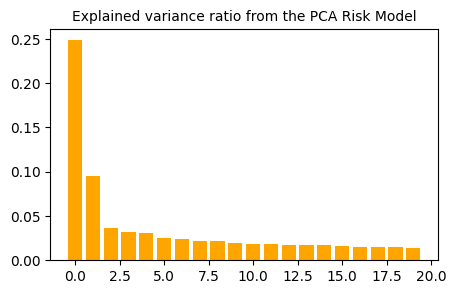

In [42]:
# visualize the percent of variance
plt.figure(figsize = (5,3))
plt.bar(np.arange(N_FACTOR_EXPOSURES), pca.explained_variance_ratio_, color = 'orange')
plt.title('Explained variance ratio from the PCA Risk Model', size = 10)

<h1 style="color:orange">Alpha Factor Evaluation</h1>

In [43]:
# calculate factor return for each factor and each ticker
factor_return_by_ticker_df = pd.DataFrame()
for ticker in test_tickers:
    ticker_exposure = factor_exposure_df.loc[ticker]
    ticker_common_return_df = factor_return_df * ticker_exposure
    ticker_common_return_df['ticker'] = ticker
    factor_return_by_ticker_df = pd.concat([factor_return_by_ticker_df, ticker_common_return_df])

factor_return_by_ticker_df = factor_return_by_ticker_df.reset_index().set_index(['date', 'ticker'])

In [54]:
factor_data_dict = dict()
for factor in factor_names:
    print(f'Formatting factor data for {factor}')
    factor_data_dict[factor] = al.utils.get_clean_factor_and_forward_returns(
        factor = factor_return_by_ticker_df[factor],
        prices = close_df_pivot[test_tickers],
        periods = [1],
        max_loss = 0.4
    )

Formatting factor data for avg_return
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!
Formatting factor data for median_return
Dropped 37.4% entries from factor data: 0.0% in forward returns computation and 37.4% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!


In [55]:
factor_return_list = []
for factor in factor_names:
    factor_return = al.performance.factor_returns(factor_data_dict[factor])
    factor_return.columns = [factor]
    factor_return_list.append(factor_return)

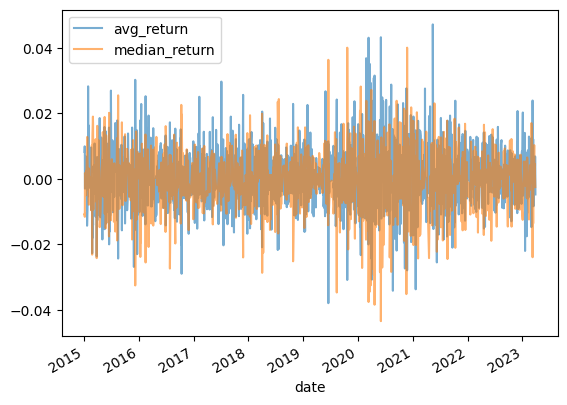

In [63]:
alpha = 0.6
factor_return_list[0]['avg_return'].plot(alpha = alpha)
factor_return_list[1]['median_return'].plot(alpha = alpha)
plt.legend()

In [58]:
# Sharpe ratio
def sharpe_ratio(df, frequency:str = "daily"):
    if frequency == "daily":
        annualization_factor = np.sqrt(252)
    elif frequency == "monthly":
        annualization_factor = np.sqrt(12)
    else:
        annualization_factor = 1
        
    sharpe_ratio = annualization_factor * (df.mean() / df.std())
    
    return sharpe_ratio


In [60]:
for factor_return in factor_return_list:
    sharpe = sharpe_ratio(factor_return)
    print(f'Sharpe Ratio for factor {factor} is {sharpe}')

Sharpe Ratio for factor median_return is avg_return    1.031868
dtype: float64
Sharpe Ratio for factor median_return is median_return   -1.054575
dtype: float64


In [61]:
# information coefficient
rank_ic_list = []

for factor in factor_names:
    rank_ic = al.performance.factor_information_coefficient(factor_data_dict[factor])
    rank_ic.columns = [factor]
    rank_ic_list.append(rank_ic)